## <font color=blue> Problem Statement: </font>

Phishing is a type of fraud in which an attacker impersonates a reputable company or
person in order to get sensitive information such as login credentials or account
information via email or other communication channels. Phishing is popular among
attackers because it is easier to persuade someone to click a malicious link that appears
to be authentic than it is to break through a computer's protection measures.


# Quick Links

1. [Libraries](#section-1)
2. [EDA and Preprocessing](#section-2)
3. [Over Sampling](#section-3)
4. [Outlier handling](#section-4)
5. [Data analysis after scaling and outlier handling](#section-5)
6. [correlatiion and heatmap](#section-6)
7. [p_value and variance inflation factor](#section-7)
8. [Model Building](#section-8)
9. [Decision Tree model, ploting of DT and saving the DT plot in png format](#section-9)
10. [Creating our Best model](#section-10)
11. [ROC Curve](#section-11)
12. [Classification Report](#section-12)

# **<a id="section-1"></a><font color='3D87A6'> Libraries </font>**

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import pandas as pd
import itertools
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from lightgbm import LGBMClassifier
import os
import seaborn as sns
from wordcloud import WordCloud
pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
filterwarnings("ignore")

# **<a id="section-2"></a><font color='3D87A6'> EDA and Preprocessing </font>**

In [4]:
data = pd.read_csv("malicious_phish.csv")
df = data.copy()
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [5]:
df.duplicated().sum()

10066

In [6]:
df.shape

(651191, 2)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [8]:
df.describe()

,url,type
count,651191,651191
unique,641119,4
top,http://style.org.hc360.com/css/detail/mysite/s...,benign
freq,180,428103


In [9]:
df.dtypes

url     object
type    object
dtype: object

## checking null values from our dataset

In [10]:
df.isna().sum().sum()

0

### There is no null value present in our data

In [15]:
df.type.value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [16]:
df_phish = df[df.type=='phishing']
df_malware = df[df.type=='malware']
df_deface = df[df.type=='defacement']
df_benign = df[df.type=='benign']

In [17]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


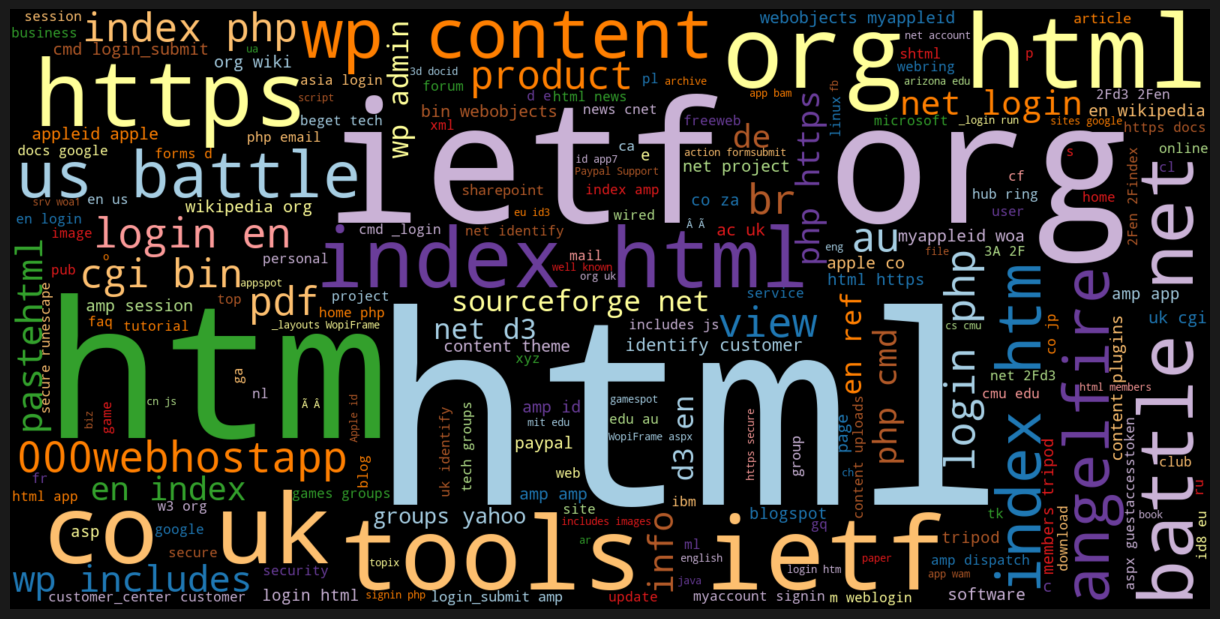

In [18]:
phish_url = " ".join(i for i in df_phish.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(phish_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

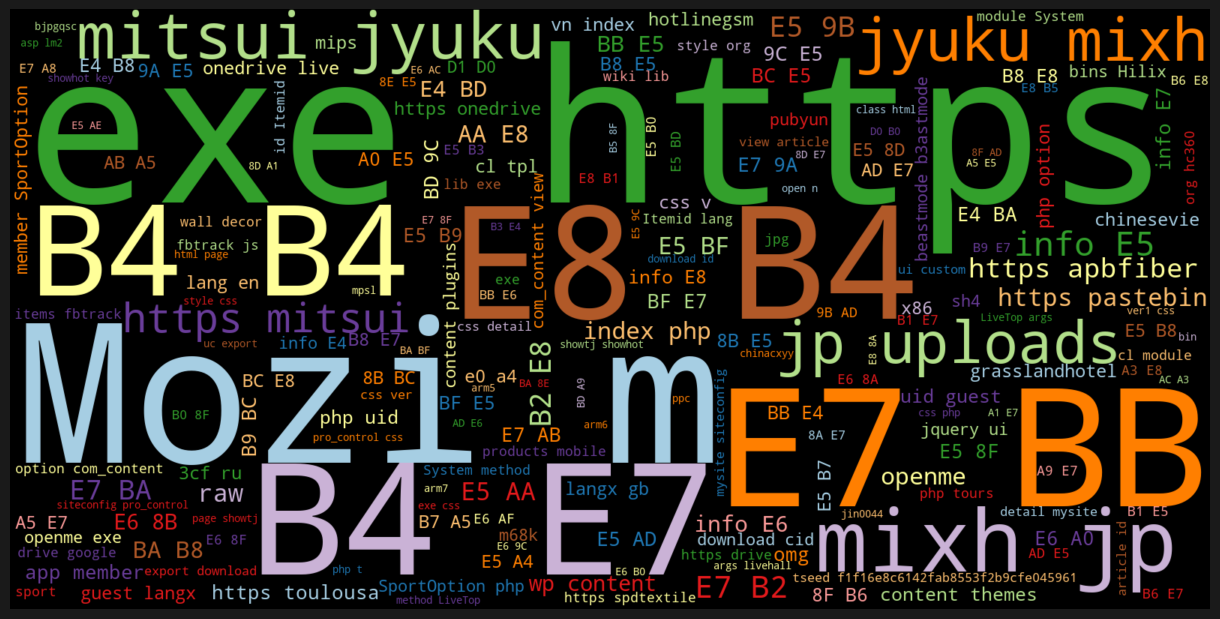

In [19]:
malware_url = " ".join(i for i in df_malware.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(malware_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

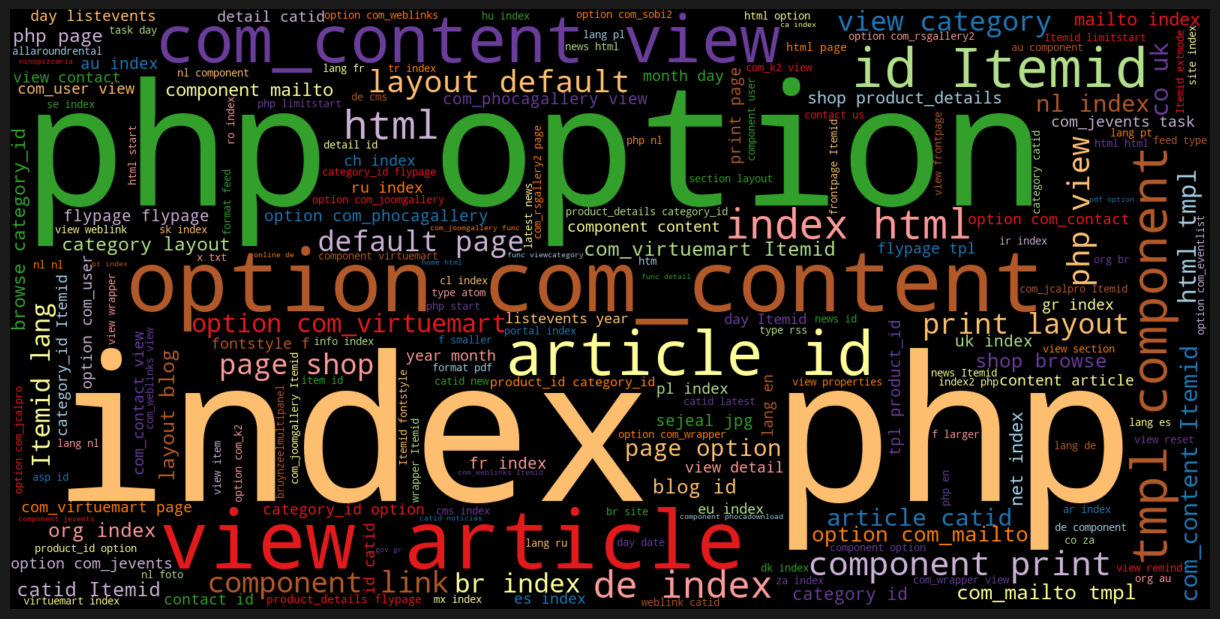

In [20]:
deface_url = " ".join(i for i in df_deface.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(deface_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

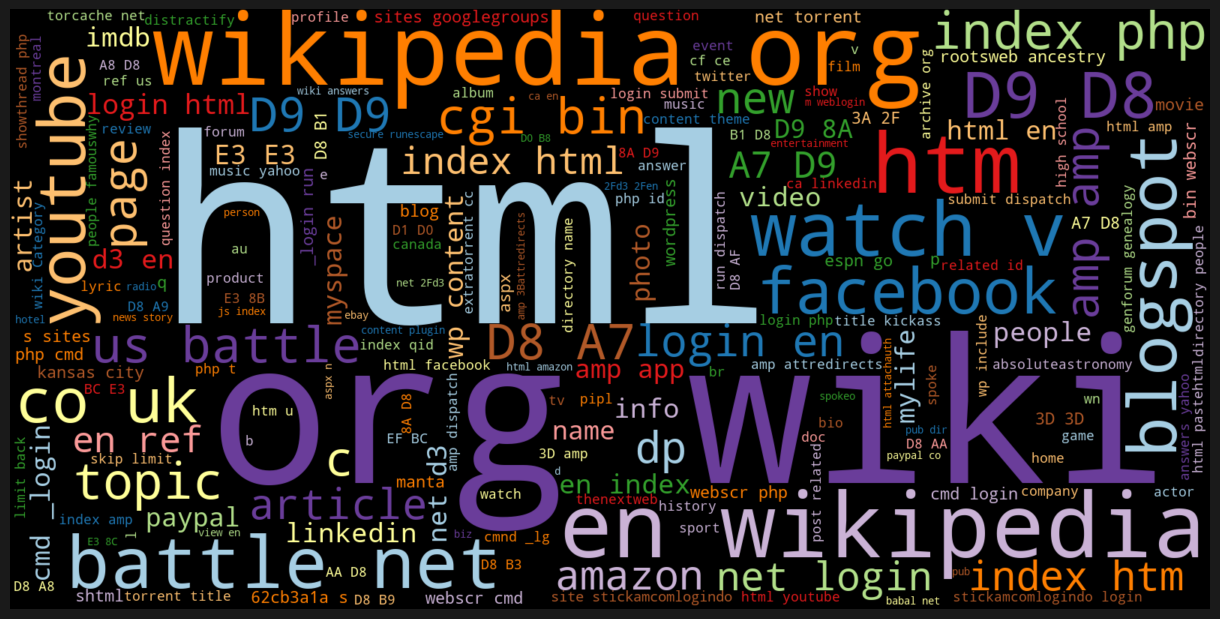

In [21]:
benign_url = " ".join(i for i in df_benign.url)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Feature Engineering

In [22]:
import re
#Use of IP or not in domain
def having_ip_address(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0
df['use_of_ip'] = df['url'].apply(lambda i: having_ip_address(i))

In [23]:
from urllib.parse import urlparse

def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        # print match.group()
        return 1
    else:
        # print 'No matching pattern found'
        return 0


df['abnormal_url'] = df['url'].apply(lambda i: abnormal_url(i))

In [25]:
!pip install googlesearch-python

     ------------------------------------ 115.8/115.8 kB 564.5 kB/s eta 0:00:00
     -------------------------------------- 61.2/61.2 kB 822.2 kB/s eta 0:00:00
     -------------------------------------- 58.8/58.8 kB 622.7 kB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.4
    Uninstalling idna-3.4:
      Successfully uninstalled idna-3.4
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.11.1
    Uninstalling beautifulsoup4-4.11.1:
      Successfully uninstalled beautifulsoup4-4.11.1
  Attempting uninstall: requests
    Found existing installation: requests 2.28.1
    Uninstalling requests-2.28.1:
      Successfully uninstalled requests-2.28.1


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
conda-repo-cli 1.0.4 requires pathlib, which is not installed.
anaconda-project 0.9.1 requires ruamel-yaml, which is not installed.
yfinance 0.2.3 requires beautifulsoup4>=4.11.1, but you have beautifulsoup4 4.9.3 which is incompatible.
yfinance 0.2.3 requires requests>=2.26, but you have requests 2.25.1 which is incompatible.
sphinx 4.0.1 requires MarkupSafe<2.0, but you have markupsafe 2.0.1 which is incompatible.
pandas-profiling 3.3.0 requires numpy<1.24,>=1.16.0, but you have numpy 1.24.2 which is incompatible.


In [26]:
from googlesearch import search

In [27]:
def google_index(url):
    site = search(url, 5)
    return 1 if site else 0
df['google_index'] = df['url'].apply(lambda i: google_index(i))

In [28]:
def count_dot(url):
    count_dot = url.count('.')
    return count_dot

df['count.'] = df['url'].apply(lambda i: count_dot(i))
df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.
0,br-icloud.com.br,phishing,0,0,1,2
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2


In [29]:
def count_www(url):
    url.count('www')
    return url.count('www')

df['count-www'] = df['url'].apply(lambda i: count_www(i))

def count_atrate(url):
     
    return url.count('@')

df['count@'] = df['url'].apply(lambda i: count_atrate(i))


def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')

df['count_dir'] = df['url'].apply(lambda i: no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')

df['count_embed_domian'] = df['url'].apply(lambda i: no_of_embed(i))


def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
    
    
df['short_url'] = df['url'].apply(lambda i: shortening_service(i))

In [30]:
def count_https(url):
    return url.count('https')

df['count-https'] = df['url'].apply(lambda i : count_https(i))

def count_http(url):
    return url.count('http')

df['count-http'] = df['url'].apply(lambda i : count_http(i))

In [31]:
def count_per(url):
    return url.count('%')

df['count%'] = df['url'].apply(lambda i : count_per(i))

def count_ques(url):
    return url.count('?')

df['count?'] = df['url'].apply(lambda i: count_ques(i))

def count_hyphen(url):
    return url.count('-')

df['count-'] = df['url'].apply(lambda i: count_hyphen(i))

def count_equal(url):
    return url.count('=')

df['count='] = df['url'].apply(lambda i: count_equal(i))

def url_length(url):
    return len(str(url))


#Length of URL
df['url_length'] = df['url'].apply(lambda i: url_length(i))
#Hostname Length

def hostname_length(url):
    return len(urlparse(url).netloc)

df['hostname_length'] = df['url'].apply(lambda i: hostname_length(i))

df.head()

def suspicious_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
df['sus_url'] = df['url'].apply(lambda i: suspicious_words(i))


def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits


df['count-digits']= df['url'].apply(lambda i: digit_count(i))


def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters


df['count-letters']= df['url'].apply(lambda i: letter_count(i))

df.head()

,url,type,use_of_ip,abnormal_url,google_index,count.,count-www,count@,count_dir,count_embed_domian,short_url,count-https,count-http,count%,count?,count-,count=,url_length,hostname_length,sus_url,count-digits,count-letters
0,br-icloud.com.br,phishing,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,16,0,0,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,35,0,0,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,2,0,0,3,0,0,0,0,0,0,0,0,31,0,0,1,25
3,http://www.garage-pirenne.be/index.php?option=...,defacement,0,1,1,3,1,0,1,0,0,0,1,0,1,1,4,88,21,0,7,63
4,http://adventure-nicaragua.net/index.php?optio...,defacement,0,1,1,2,0,0,1,0,0,0,1,0,1,1,3,235,23,0,22,199


In [32]:
#Importing dependencies
from urllib.parse import urlparse
from tld import get_tld
import os.path

#First Directory Length
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0

df['fd_length'] = df['url'].apply(lambda i: fd_length(i))

#Length of Top Level Domain
df['tld'] = df['url'].apply(lambda i: get_tld(i,fail_silently=True))


def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1

df['tld_length'] = df['tld'].apply(lambda i: tld_length(i))

In [33]:
df = df.drop("tld",1)

In [34]:
df.columns

Index(['url', 'type', 'use_of_ip', 'abnormal_url', 'google_index', 'count.',
       'count-www', 'count@', 'count_dir', 'count_embed_domian', 'short_url',
       'count-https', 'count-http', 'count%', 'count?', 'count-', 'count=',
       'url_length', 'hostname_length', 'sus_url', 'count-digits',
       'count-letters', 'fd_length', 'tld_length'],
      dtype='object')

In [35]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

## EDA

# **<a id="section-3"></a><font color='3D87A6'> 3.oversampling</font>**

In [17]:
x=df.drop("quality",axis=1)
y=df.quality

In [18]:
y.value_counts()

0    1382
1     217
Name: quality, dtype: int64

### from the above visualization we can easily conclude that our data is very imbalanced data

## Balancing our data by using the oversampling technique

In [19]:
from imblearn.over_sampling import SMOTE
x_resampled, y_resampled = SMOTE().fit_resample(x, y)

In [20]:
y_resampled.value_counts()

0    1382
1    1382
Name: quality, dtype: int64

In [21]:
df = pd.concat([x_resampled,y_resampled],axis = 1)

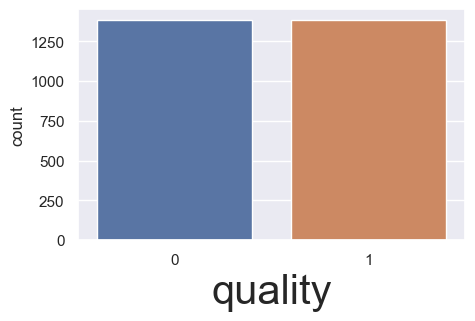

In [22]:
plt.figure(figsize=(5,3))
sns.countplot(df["quality"])
plt.xlabel(column,fontsize=30)
plt.show()

### scaling numerical data using Minmaxscaler

In [23]:
from sklearn.preprocessing import MinMaxScaler

In [24]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)
df = pd.DataFrame(scaled_data,columns = df.columns)
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.0
1,0.283186,0.520548,0.00,0.116438,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,0.0
2,0.283186,0.438356,0.04,0.095890,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,0.0
3,0.584071,0.109589,0.56,0.068493,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,0.0
4,0.247788,0.397260,0.00,0.068493,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.0


# **<a id="section-4"></a><font color='3D87A6'> Outlier Handling </font>**

### There is also chance of outliers in our dataset, so to check outlier I'm using the boxplot method

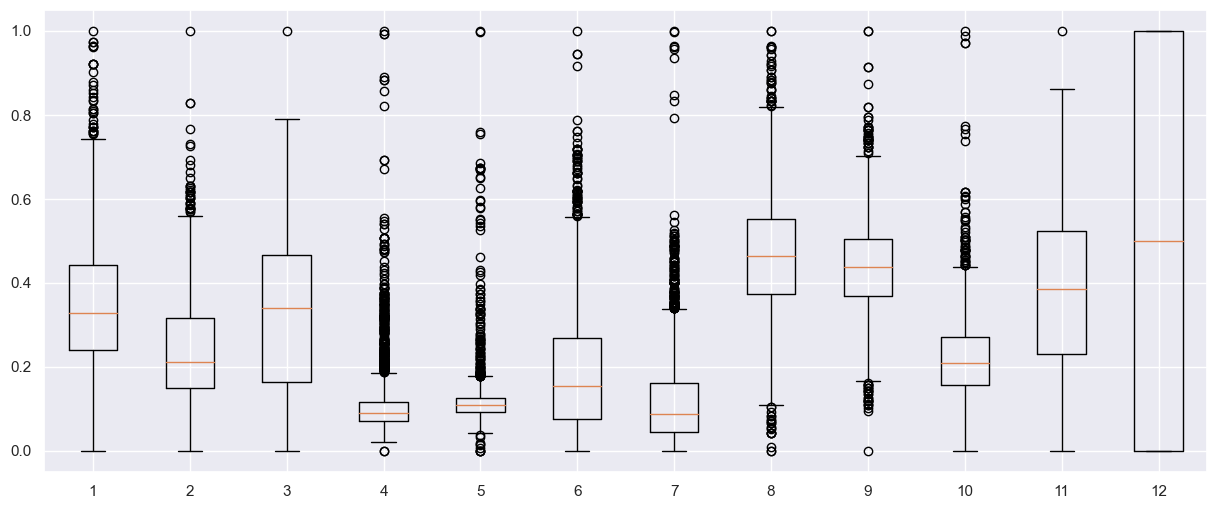

In [25]:
plt.figure(figsize=(15,6))
plt.boxplot(df)
plt.show()

## outliers handling with statical aproach (using IQR method)

In [26]:
for feature in df.columns:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_fence = Q1-1.5*IQR
    upper_fence = Q3+1.5*IQR
    for i in range(len(df)):
        outlier = df[feature][i]
        if outlier > upper_fence:
            df[feature][i] = upper_fence
        elif outlier < lower_fence:
            df[feature][i] = lower_fence

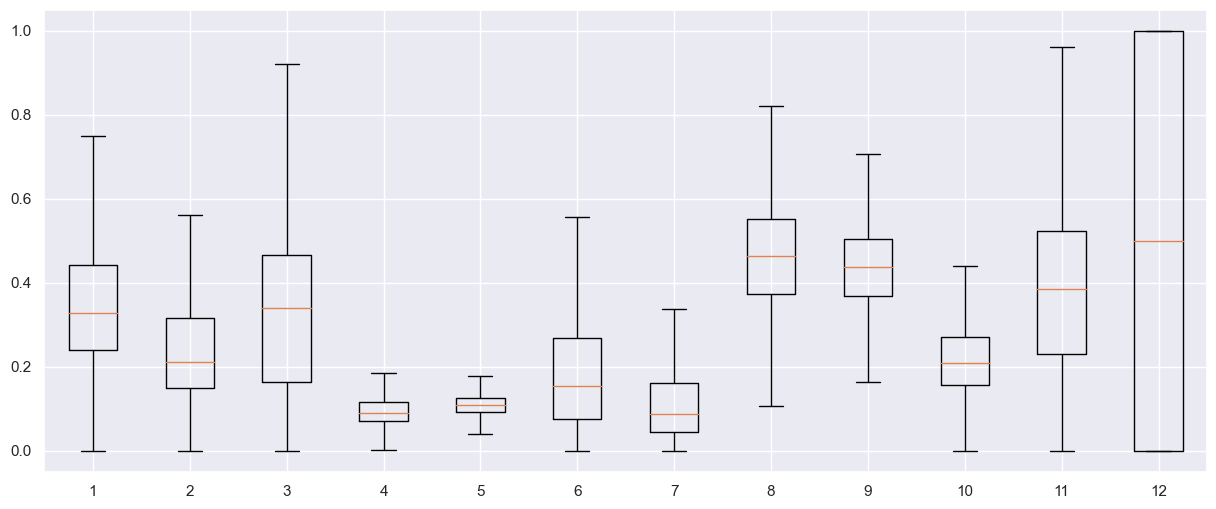

In [27]:
plt.figure(figsize=(15,6))
plt.boxplot(df)
plt.show()

### Now its clearly visible in boxplot there is no outlier in our numercal data

# **<a id="section-5"></a><font color='3D87A6'> Analysis after scaling and outlier handling </font>**

## Now we have scaled data. Now we can analyse our data by using visualizaion

In [28]:
x = df.drop("quality",axis = 1)
y = df.quality

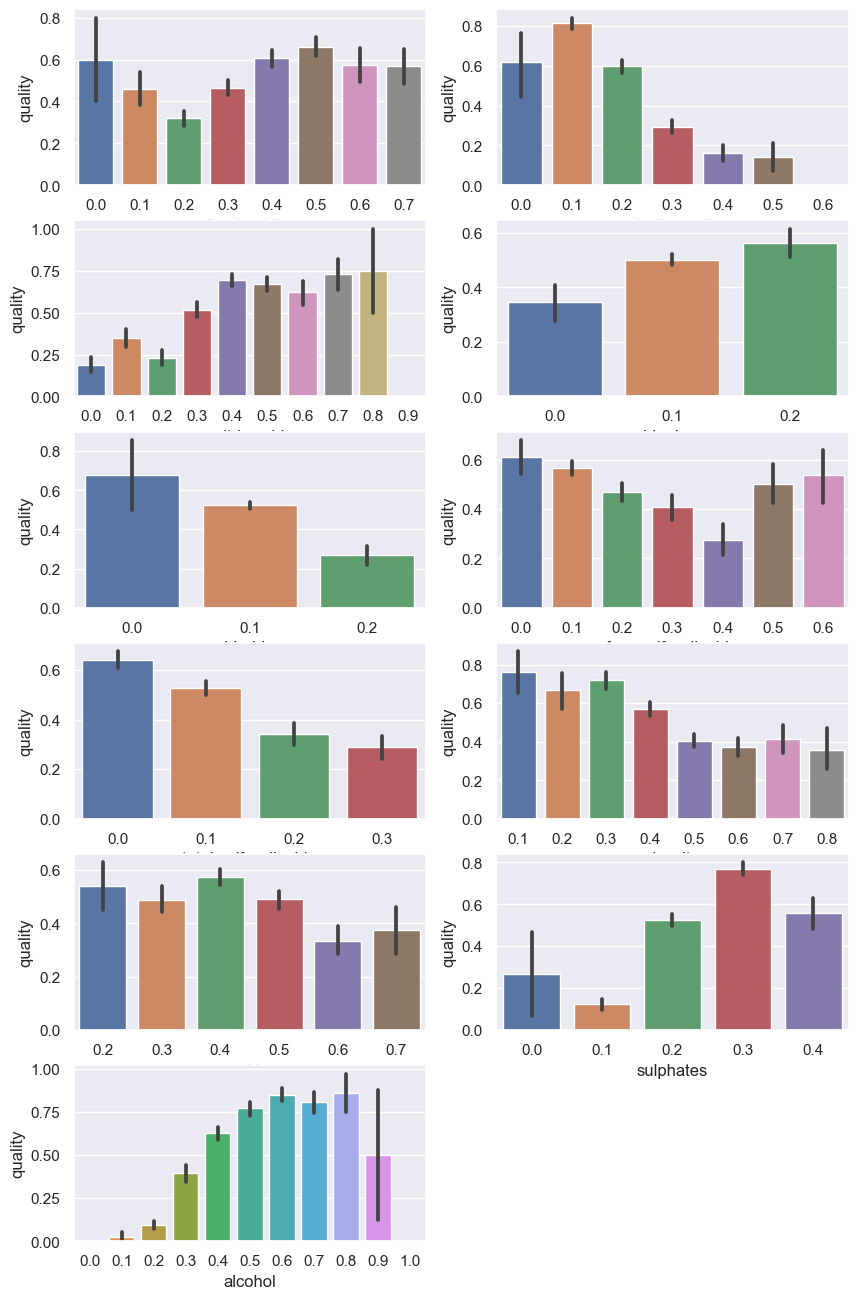

In [29]:
plt.figure(figsize=(10,16))
sns.set()
for i, feature in enumerate(x.columns):
    plt.subplot(6,2,i+1)
    sns.barplot(x.apply(lambda x: round(x,1))[feature],y)

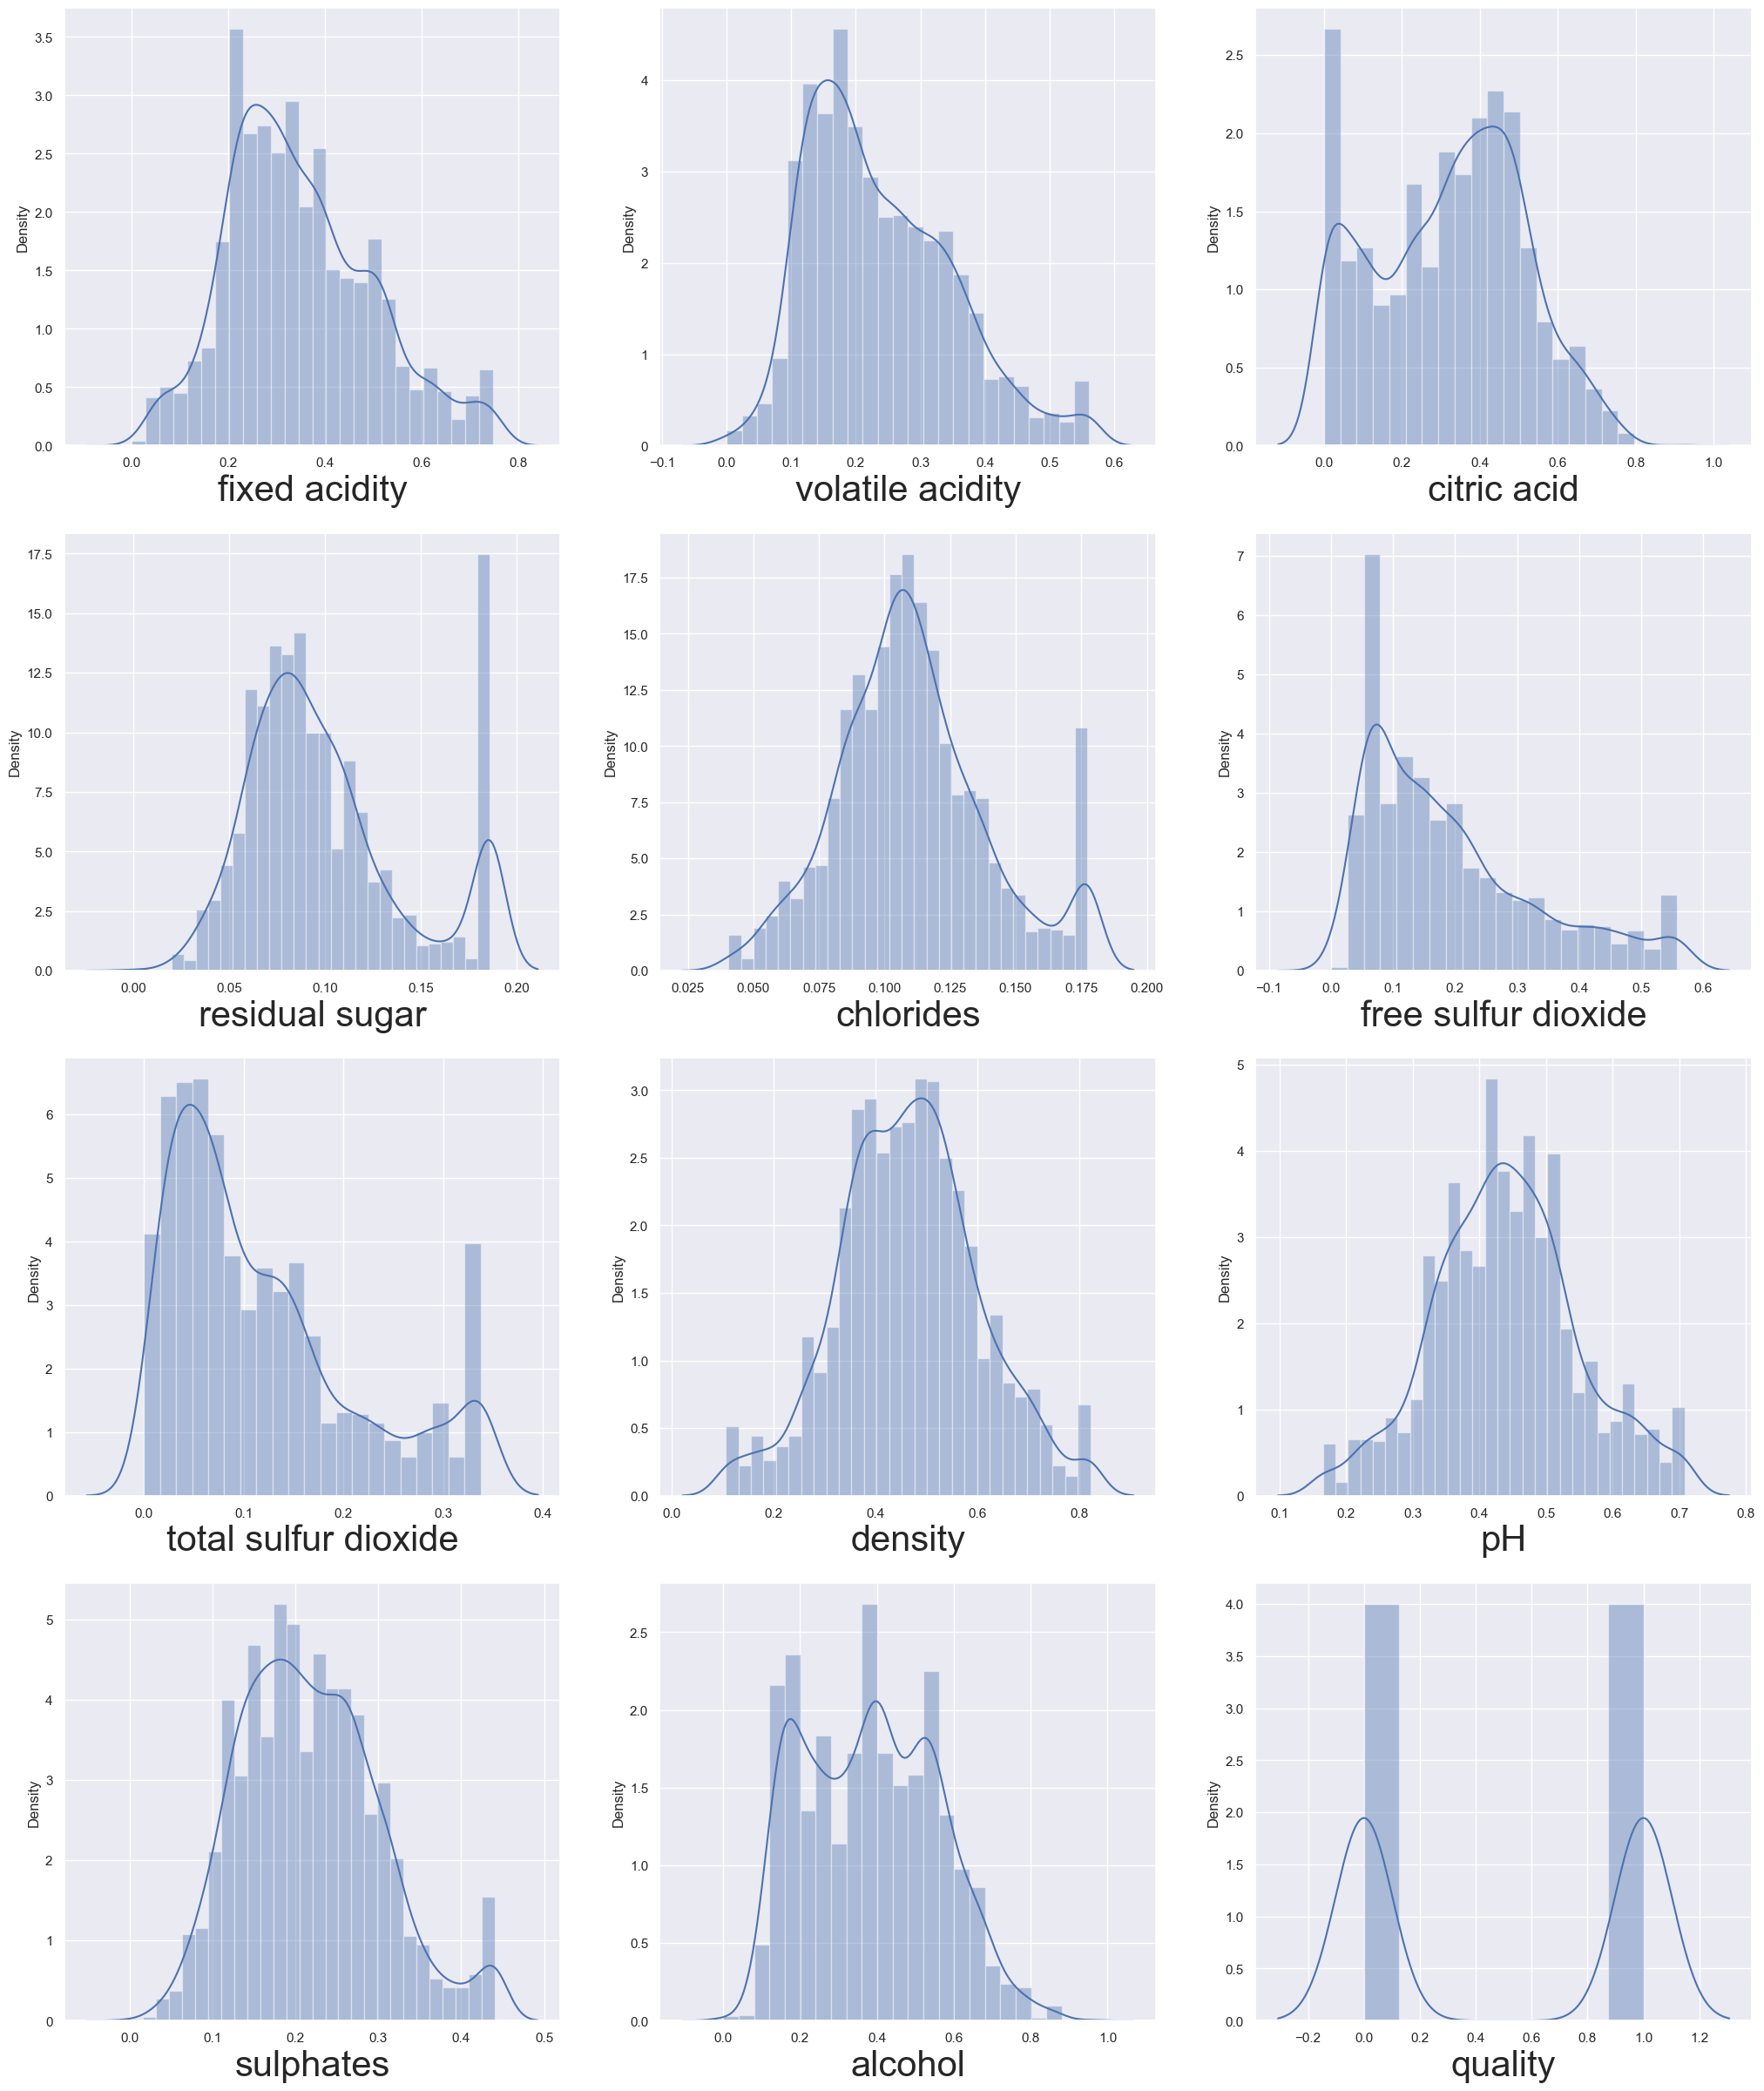

In [30]:
# Analysing the distribution of data.
plt.figure(figsize=(25,30),facecolor='white')
plotnumber = 1
sns.set()
for column in df:
    if plotnumber <= 12:
        ax = plt.subplot(4,3,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=30)
    plotnumber += 1
plt.show()

# **<a id="section-6"></a><font color='3D87A6'> Correlation and heatmap </font>**

In [31]:
corr = df.corr()
z = corr.style.highlight_between(left=-1,right=-0.90,color='red').highlight_between(left=0.90,right=1,color='red')
z

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.311259,0.725252,0.256992,0.265888,-0.179539,-0.207790,0.664561,-0.729483,0.231176,-0.083563,0.186235
volatile acidity,-0.311259,1.000000,-0.594045,0.022755,0.187753,0.060559,0.196414,0.088482,0.275632,-0.374939,-0.310463,-0.468507
citric acid,0.725252,-0.594045,1.000000,0.265647,0.144626,-0.106068,-0.120905,0.343834,-0.609449,0.349127,0.180206,0.351544
residual sugar,0.256992,0.022755,0.265647,1.000000,0.249393,0.032602,0.074497,0.399116,-0.137452,0.017755,0.129615,0.089677
chlorides,0.265888,0.187753,0.144626,0.249393,1.000000,-0.067772,0.001110,0.485170,-0.256365,0.001652,-0.344580,-0.230747
free sulfur dioxide,-0.179539,0.060559,-0.106068,0.032602,-0.067772,1.000000,0.729493,-0.023185,0.118142,0.009134,-0.098615,-0.114570
total sulfur dioxide,-0.207790,0.196414,-0.120905,0.074497,0.001110,0.729493,1.000000,0.049022,0.085756,-0.044855,-0.212332,-0.258000
density,0.664561,0.088482,0.343834,0.399116,0.485170,-0.023185,0.049022,1.000000,-0.362347,0.098410,-0.558152,-0.228819
pH,-0.729483,0.275632,-0.609449,-0.137452,-0.256365,0.118142,0.085756,-0.362347,1.000000,-0.127094,0.169834,-0.102150
sulphates,0.231176,-0.374939,0.349127,0.017755,0.001652,0.009134,-0.044855,0.098410,-0.127094,1.000000,0.240899,0.399528


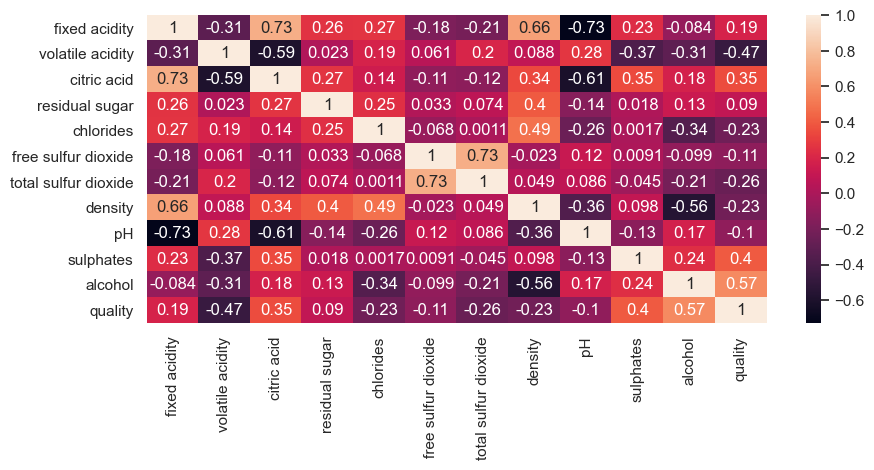

In [32]:
plt.figure(figsize=(10,4))
sns.heatmap(corr,annot = True)
plt.show()

# **<a id="section-7"></a><font color='3D87A6'> p_value and variance inflation factor </font>**
### checking 'P>|t|' > 0.05 and vif > 5

In [33]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
x = sm.add_constant(x)

In [34]:
sm_model = sm.Logit(y,x).fit()

Optimization terminated successfully.
         Current function value: 0.384737
         Iterations 7


In [35]:
sm_model.pvalues

const                   1.096651e-04
fixed acidity           3.783350e-05
volatile acidity        1.413458e-12
citric acid             4.175354e-01
residual sugar          7.007994e-06
chlorides               1.274162e-05
free sulfur dioxide     8.690583e-04
total sulfur dioxide    2.460914e-12
density                 8.767941e-04
pH                      9.473723e-01
sulphates               4.049172e-34
alcohol                 6.435466e-21
dtype: float64

In [36]:
## creating the function to create dataframe to show vif and p_value at a time to comapare both wrt that feature(column)

In [37]:
def df_of_vif_pvalue():
    p_value_df = pd.DataFrame(sm_model.pvalues.apply(lambda x: round(x,6))).reset_index()
    p_value_df.columns=["feature_names",'p_values']
    def VIF(x):
        vif_df = pd.DataFrame()
        vif_df["feature_names"] = x.columns
        vif_df["vif"] = [variance_inflation_factor(x.values,i) for i in range(x.shape[1])]
        vif_df["vif"] = round(vif_df["vif"],2)
        vif_df = vif_df.sort_values(by = "vif",ascending = False)
        return vif_df
    global vif_pvalue_df
    vif_pvalue_df = pd.merge(p_value_df,VIF(x), on = "feature_names")
    return vif_pvalue_df

## creating the function to check high vif and p_value both

In [38]:
def High_vif_pvalue(vif_pvalue_df):
    global lst_feature_to_del
    lst_feature_to_del = []
    '''vif_pvalue is a DataFrame having pvalues and vif'''
    for i in range(len(vif_pvalue_df)):
        if vif_pvalue_df["vif"][i] > 5 and vif_pvalue_df["p_values"][i] >0.05:
            lst_feature_to_del.append(vif_pvalue_df["feature_names"][i])
    return lst_feature_to_del

In [39]:
df_of_vif_pvalue()

,feature_names,p_values,vif
0,const,0.000110,120.12
1,fixed acidity,0.000038,8.41
2,volatile acidity,0.000000,2.11
3,citric acid,0.417535,3.71
4,residual sugar,0.000007,2.00
5,chlorides,0.000013,1.46
6,free sulfur dioxide,0.000869,2.23
7,total sulfur dioxide,0.000000,2.50
8,density,0.000877,8.56
9,pH,0.947372,3.54


In [40]:
## checking the features whose vif and p_value both are high
High_vif_pvalue(vif_pvalue_df)

[]

### from above it is clearly seems that there is no such feature which has high both vif and pvalue 

#### There is no feature having vif value greater than 5.So now check p_value only.

In [41]:
def check_pvalue(vif_pvalue_df,P_value_column):
    High_vif_features = {}
    for i,value in enumerate(P_value_column):
        if value > 0.05:
            High_vif_features[vif_pvalue_df.loc[i][0]] = value
    return High_vif_features

In [42]:
check_pvalue(vif_pvalue_df,vif_pvalue_df["p_values"])

{'citric acid': 0.417535, 'pH': 0.947372}

# **<a id="section-8"></a><font color='3D87A6'> Model Building </font>**

In [43]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=36)

In [44]:
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((2211, 12), (2211,), (553, 12), (553,))

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier,BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [46]:
model_params = {
    'svc': {'model': SVC(gamma ="auto"),
            'params' : {
                "C" :[1, 10,100,201],
                'kernel': [ 'rbf','linear']}
           },
    "random_forest": {'model' : RandomForestClassifier(),
                      'params' : {'n_estimators' : [200,250,100,150,300]}
                     },
    'logistic_regression' : {
        'model' : LogisticRegression(solver = "liblinear"),
        'params':{"C" : [1,5,10,50]}
    },
    "GradientBoostingClassifier":{"model": GradientBoostingClassifier(),
                                "params" : {'learning_rate':[0.1,0.2,0.3,0.4],'n_estimators':list(range(1,300,50)),'subsample':[1.0,2.0,3.0,4.0],'criterion':['friedman_mse']}
                                  },
    "KNN" : {"model" : KNeighborsClassifier(),
            "params" : {"n_neighbors":list(range(3,35,6)),'weights':['uniform'],'algorithm':['auto'],'leaf_size':list(range(10,100,15)),'p':[2,4,5,6],'metric':['minkowski']}
            }
    }

In [47]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp['params'], cv =10, return_train_score = False)
    clf.fit(x, y)
    scores.append({
        "model" : model_name,
        'best_score': clf.best_score_,
        'best_params' : clf.best_params_})
mod_df = pd.DataFrame(scores,columns = ["model","best_score","best_params"])
mod_df

,model,best_score,best_params
0,svc,0.826699,"{'C': 201, 'kernel': 'rbf'}"
1,random_forest,0.915699,{'n_estimators': 300}
2,logistic_regression,0.820549,{'C': 50}
3,GradientBoostingClassifier,0.920427,"{'criterion': 'friedman_mse', 'learning_rate':..."
4,KNN,0.880580,"{'algorithm': 'auto', 'leaf_size': 10, 'metric..."


In [48]:
model_params = {
    'decision_tree': {'model': DecisionTreeClassifier(),
            'params' : {
                "criterion" :["gini", "entropy", "log_loss"],
                'splitter': [ 'best'],
                "min_samples_split": [2,4,6],
                'random_state': [36]}
           },
    "AdaBoostDT": {'model' : AdaBoostClassifier(),
                   'params' : {'n_estimators' : [10,50,100,150,200],
                               'learning_rate':[0.1,0.2,0.3,0.4],
                               "algorithm" : ['SAMME', 'SAMME.R']}
                     },
    'xgboost_classifier' : {'model' : XGBClassifier(),
        'params':{"n_estimators" : [1,30,100,150,200],
                 'learning_rate':[0.1,0.2,0.3,0.4],
                 }
                           }
}

In [49]:
scores = []

for model_name, mp in model_params.items():
    clf = GridSearchCV(mp["model"],mp['params'], cv =10, return_train_score = False)
    clf.fit(x, y)
    scores.append({
        "model" : model_name,
        'best_score': clf.best_score_,
        'best_params' : clf.best_params_})
mod_df1 = pd.DataFrame(scores,columns = ["model","best_score","best_params"])
mod_df1

,model,best_score,best_params
0,decision_tree,0.878079,"{'criterion': 'entropy', 'min_samples_split': ..."
1,AdaBoostDT,0.858900,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2,..."
2,xgboost_classifier,0.925111,"{'learning_rate': 0.3, 'n_estimators': 150}"


In [50]:
modeles_df = pd.concat([mod_df,mod_df1]).set_index('model',drop = True)
modeles_df

,best_score,best_params
model,,
svc,0.826699,"{'C': 201, 'kernel': 'rbf'}"
random_forest,0.915699,{'n_estimators': 300}
logistic_regression,0.820549,{'C': 50}
GradientBoostingClassifier,0.920427,"{'criterion': 'friedman_mse', 'learning_rate':..."
KNN,0.880580,"{'algorithm': 'auto', 'leaf_size': 10, 'metric..."
decision_tree,0.878079,"{'criterion': 'entropy', 'min_samples_split': ..."
AdaBoostDT,0.858900,"{'algorithm': 'SAMME.R', 'learning_rate': 0.2,..."
xgboost_classifier,0.925111,"{'learning_rate': 0.3, 'n_estimators': 150}"


# **<a id="section-9"></a><font color='3D87A6'> Decision tree model </font>**

### first we creating the decision tree model to show the plot of decision tree and then we create our best model i.e.xgboost_classifier model

In [51]:
best_parameter_for_decision_tree = modeles_df.loc["decision_tree"]['best_params']
best_parameter_for_decision_tree

{'criterion': 'entropy',
 'min_samples_split': 4,
 'random_state': 36,
 'splitter': 'best'}

In [52]:
model_decision_tree= DecisionTreeClassifier(criterion = 'entropy', min_samples_split= 6, splitter ='best',random_state=36)
model_decision_tree.fit(x_train,y_train)

DecisionTreeClassifier(criterion='entropy', min_samples_split=6,
                       random_state=36)

In [53]:
model_decision_tree.score(x_test,y_test)

0.895117540687161

['0.0', '1.0']


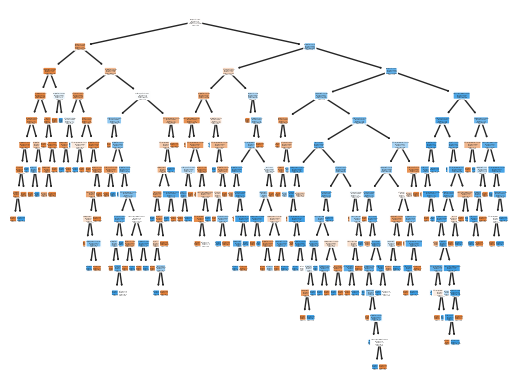

<Figure size 2500x1600 with 0 Axes>

In [54]:
from sklearn.tree import plot_tree


feature_names = x.columns  ##Xvariables
target_names = y.unique().tolist()
target_names=[str(i) for i in target_names]
print(target_names)#list of target classes

plot_tree(model_decision_tree,
          feature_names = feature_names,
          class_names = target_names,
          filled=True,
          rounded=True
          )
plt.figure(figsize=(25,16))
plt.savefig('tree.png') ##plt.savefig to save in given file name

In [55]:
y_test_pred_dt=model_decision_tree.predict(x_test)

In [56]:
print("accuracy of best model(decision_tree) : ",accuracy_score(y_test,y_test_pred_dt)*100,"%")

accuracy of best model(decision_tree) :  89.5117540687161 %


In [57]:
print(classification_report(y_test,y_test_pred_dt))

              precision    recall  f1-score   support

         0.0       0.89      0.90      0.89       267
         1.0       0.90      0.90      0.90       286

    accuracy                           0.90       553
   macro avg       0.89      0.90      0.90       553
weighted avg       0.90      0.90      0.90       553



# **<a id="section-10"></a><font color='3D87A6'> Creating our best model </font>**

In [58]:
best_parameter_for_xgboost_classifier = modeles_df.loc["xgboost_classifier"]['best_params']
best_parameter_for_xgboost_classifier

{'learning_rate': 0.3, 'n_estimators': 150}

In [59]:
model_xgboost_classifier= XGBClassifier(learning_rate=0.3,n_estimators=200)
model_xgboost_classifier.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.3, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [60]:
y_test_pred = model_xgboost_classifier.predict(x_test)

In [61]:
accuracy_score(y_test,y_test_pred)

0.9349005424954792

In [62]:
cm = confusion_matrix(y_test,y_test_pred)
cm

array([[249,  18],
       [ 18, 268]], dtype=int64)

In [63]:
TN=cm[0,0]
TP=cm[1,1]
FN=cm[1,0]
FP=cm[0,1]
sensitivity=TP/float(TP+FN)
specificity=TN/float(TN+FP)

In [64]:
print('The acuuracy of the model = TP+TN/(TP+TN+FP+FN) = ',(TP+TN)/float(TP+TN+FP+FN),'\n\n',

'Missclassifications = 1-Accuracy = ',1-((TP+TN)/float(TP+TN+FP+FN)),'\n\n',

'Sensitivity/Recall or True Positive Rate = TP/(TP+FN) = ',TP/float(TP+FN),'\n\n',

'Specificity or True Negative Rate = TN/(TN+FP) = ',TN/float(TN+FP),'\n\n',

'Precision/Positive Predictive value = TP/(TP+FP) = ',TP/float(TP+FP),'\n\n',

'Negative predictive Value = TN/(TN+FN) = ',TN/float(TN+FN),'\n\n',

'Positive Likelihood Ratio = Sensitivity/(1-Specificity) = ',sensitivity/(1-specificity),'\n\n',

'Negative likelihood Ratio = (1-Sensitivity)/Specificity = ',(1-sensitivity)/specificity)

The acuuracy of the model = TP+TN/(TP+TN+FP+FN) =  0.9349005424954792 

 Missclassifications = 1-Accuracy =  0.06509945750452084 

 Sensitivity/Recall or True Positive Rate = TP/(TP+FN) =  0.9370629370629371 

 Specificity or True Negative Rate = TN/(TN+FP) =  0.9325842696629213 

 Precision/Positive Predictive value = TP/(TP+FP) =  0.9370629370629371 

 Negative predictive Value = TN/(TN+FN) =  0.9325842696629213 

 Positive Likelihood Ratio = Sensitivity/(1-Specificity) =  13.899766899766888 

 Negative likelihood Ratio = (1-Sensitivity)/Specificity =  0.06748673013733253


In [65]:
print("accuracy of best model(XGBClassifier) : ",accuracy_score(y_test,y_test_pred)*100,"%")

accuracy of best model(XGBClassifier) :  93.49005424954791 %


# **<a id="section-11"></a><font color='3D87A6'> roc curve</font>**

In [66]:
y_pred_prob = model_xgboost_classifier.predict_proba(x_test)
y_pred_prob = y_pred_prob[:,1]

In [67]:
roc_auc_score_test = roc_auc_score(y_test,y_pred_prob)
roc_auc_score_test

0.9774233257379324

In [68]:
fpr,tpr,thresholds = roc_curve(y_test,y_pred_prob)

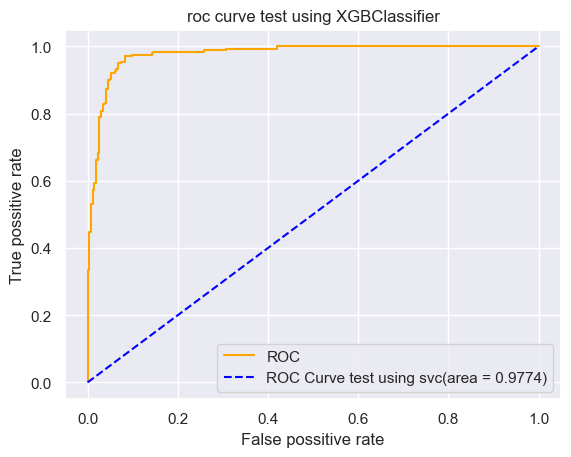

In [69]:
plt.plot(fpr,tpr,color= "orange",label = "ROC")
plt.plot([0,1],[0,1],color='blue',linestyle='--',label='ROC Curve test using svc(area = %0.4f)' % roc_auc_score_test)
plt.xlabel('False possitive rate')
plt.ylabel('True possitive rate')
plt.title('roc curve test using XGBClassifier')
plt.legend()
plt.show()

# **<a id="section-12"></a><font color='3D87A6'> Classification Report </font>**

In [70]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93       267
         1.0       0.94      0.94      0.94       286

    accuracy                           0.93       553
   macro avg       0.93      0.93      0.93       553
weighted avg       0.93      0.93      0.93       553

